# FEVER Document Retrieval

**Purpose**: the purpose of this notebook is to develop a baseline approach for scoring document retrieval on the FEVER dataset with Apache Lucene.

**Input**: This document requires the Lucene index, and JSON files to run.

## Setting up Lucene Query

In [87]:
import utils
import pickle
import pandas as pd
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import numpy as np
import seaborn as sns

In [2]:
claims, labels, article_list, claim_set, claim_to_article = utils.extract_fever_jsonl_data("../train.jsonl")

Num Distinct Claims 109810
Num Data Points 125051


## Exploring Dataset

In this section, we explore the dataset. In particular, we want to know how many pieces of evidence any given document has.

In [9]:
evidences = [len(v) for v in claim_to_article.values()]

In [86]:
print("Average evidence length: {}".format(np.mean(evidences)))
print("Standard deviation: {}".format(np.std(evidences)))

Average evidence length: 1.2224905173425096
Standard deviation: 0.7813579581892875


/home/moinnadeem/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


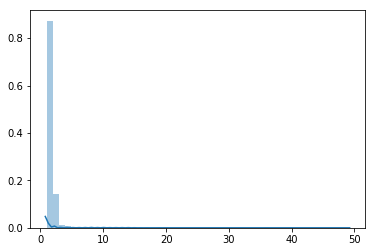

In [10]:
sns.distplot(evidences)

## Applying Statistics to Dataset

We calculate the Precision, Recall at one of (1,2,5,10).

In [12]:
k = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]

In [13]:
def score_claim(claim):
    cleaned_claim = claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, str(max(k)))
    retrieved = utils.process_lucene_output(choices)
    relevant = claim_to_article[claim]
    mAP = {}
    for i in k:
        precision = utils.calculate_precision(retrieved=retrieved, relevant=relevant, k=i)
        recall = utils.calculate_recall(retrieved=retrieved, relevant=relevant, k=i)
        mAP[i] = {}
        mAP[i]['precision'] = precision
        mAP[i]['recall'] = recall
    return mAP

We run this on the CSAIL cluster, and cache the results in a `result.pkl` file. We load this file into the notebook for the purpose of documentation.

In [90]:
loadCached = True

In [91]:
if not loadCached:
    result = Parallel(n_jobs=8, verbose=1)(delayed(score_claim)(c) for c in list(claim_to_article.keys())[:10000])
    with open("result.pkl", "wb") as f:
        pickle.dump(result, f)
else:
    with open("result.pkl", "rb") as f:
        result = pickle.load(f)

In [93]:
def calculatemAP(mAP, k):
    mAP_final = {}
    
    for i in k:
        mAP_final[i] = {}
        mAP_final[i]['precision'] = []
        mAP_final[i]['recall'] = []
        
    for ap in mAP:
        for k, v in ap.items():
            mAP_final[k]['precision'].append(v['precision'])
            mAP_final[k]['recall'].append(v['recall'])
    
    return mAP_final

def displaymAP(mAP):
    for k in sorted(mAP.keys()):
        for k_i, v_i in mAP[k].items():
            print("{} @ {}: {}".format(k_i, k, np.mean(v_i)))
        print()
            
def calculate_precision_recall(mAP):
    precision = np.zeros((len(mAP), 2))
    recall = np.zeros((len(mAP), 2))
    for idx, k in enumerate(mAP.keys()):
        precision[idx, 0] = k
        precision[idx, 1] = np.mean(mAP[k]['precision'])
        
        recall[idx, 0] = k
        recall[idx, 1] = np.mean(mAP[k]['recall'])
        
    return precision, recall

In [94]:
mAP = calculatemAP(result, k)

## Understanding our Precision, Recall

How is our accuracy on our documents?

In [95]:
data = pd.DataFrame(data=np.vstack([precision[:,1], recall[:,1]]).T, index=precision[:,0], columns=["Precision", "Recall"]).sort_index()

In [96]:
data

,Precision,Recall
1.0,0.000578,0.215833
2.0,0.000818,0.305083
5.0,0.001123,0.414750
10.0,0.001358,0.497583
20.0,0.001588,0.579750
50.0,0.001895,0.686626
100.0,0.002168,0.785126
200.0,0.002343,0.849626
300.0,0.002453,0.887293
400.0,0.002506,0.902826


How many documents are we dealing with?

In [97]:
!ls ../wiki-pages/processed_pages/ | wc -l

5415460


In [32]:
precision, recall = calculate_precision_recall(mAP)

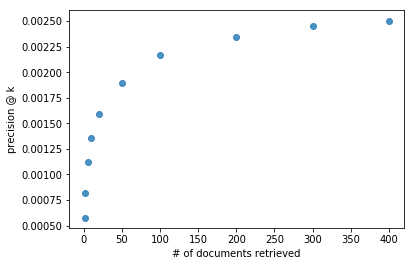

In [41]:
ax = sns.regplot(precision[:,0], precision[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="precision @ k")
ax

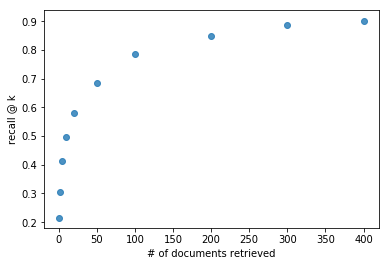

In [40]:
ax = sns.regplot(recall[:,0], recall[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="recall @ k")
ax

## Evaluating results

In this section, we just look at a few of the relevant / retrieved results in order to better understand the lookup.

In [23]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [98]:
for claim in list(claim_to_article.keys())[:3]:
    cleaned_claim = claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, "10")
    retrieved = utils.process_lucene_output(choices)
    relevant = claim_to_article[claim]
    printmd("Claim: **{}**".format(claim))
    print("Retrieved {} documents.".format(len(retrieved)))
    print()
    
    print("Relevant Documents:")
    for r in relevant:
        print(r)
    print()
    
    print("Retrieved Documents:")
    for r in retrieved:
        if r in relevant:
            printmd("*{}*".format(r))
        else:
            print(r)
    print()

Claim: **Interstellar has yet to premiere.**

Retrieved 10 documents.

Relevant Documents:
interstellar  film 
interstellar  film 

Retrieved Documents:
interstellar comet
propynylidyne
memories of matsuko
action dad
nitrogen monohydride
interstellar alliance
local interstellar cloud
g292 0 01 8
helium hydride ion
interstellar ark



Claim: **Malcolm Young co-founded AC/DC in Australia.**

Retrieved 10 documents.

Relevant Documents:
malcolm young
ac dc

Retrieved Documents:
stiff upper lip  album 
powerage
ballbreaker
tales of old grand daddy
fly on the wall  ac dc album 
stevie young
flick of the switch  song 
if you want blood you ve got it
danger  ac dc song 
gretsch g6131



Claim: **Man of Steel began principal photography in East Los Angeles.**

Retrieved 10 documents.

Relevant Documents:
man of steel  film 

Retrieved Documents:
the bachelors  film 
dude  film 
the babysitter  2017 film 
marshall  film 
the meddler
scouts guide to the zombie apocalypse
the bad batch
the house  2017 film 
all nighter  film 
national metal and steel

